In [1]:
import os
import numpy as np
import pandas as pd
import gensim

import nltk
from Litho.nlp_funcs import *
from Litho.similarity import (check_similarity, match_lithcode, jaccard_similarity, 
                              calc_similarity_score, print_sim_compare, merge_similar_words)

# from autocorrect import spell
from textblob import TextBlob, Word

stopwords = nltk.corpus.stopwords.words('english')
stopw2 = ['redish', 'reddish', 'red', 'black', 'blackish', 'brown', 'brownish',
          'blue', 'blueish', 'orange', 'orangeish', 'gray', 'grey', 'grayish',
          'greyish', 'white', 'whiteish', 'purple', 'purpleish', 'yellow',
          'yellowish', 'green', 'greenish', 'light', 'very', 'pink','coarse',
          'fine', 'medium', 'hard', 'soft', 'coloured', 'multicoloured',
          'weathered', 'fractured', 'dark', 'color', 'colour', 'clean', 'cleaner']

stopwords.extend(stopw2)

C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
path = os.getcwd()+'/'
file = 'boresTa.csv'
lith_data = pd.read_csv(path+file)

C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
token_words = [' '.join(tokenize_only(str(desc), li=[])) for desc in lith_data.Description]

In [4]:
all_words = set(token_words)

In [5]:
classified = pd.read_csv(os.path.join(path, 'classification_criteria.csv'), usecols=[9])

In [6]:
known_classes = set([x[0] for x in classified.values.tolist()])

# manually add missing class for now
known_classes.add('quartzite')  

# Sort from longest to shortest (yes, the order matters!)
# e.g. we want to capture 'siltstone' before matching 'silt'
known_classes = sorted(known_classes, key=len, reverse=True)

In [7]:
len(known_classes)

93

In [8]:
# # Build a dict of known classifications arranged alphabetically for quicker lookup
# sorted_classes = {}
# for lith_class in known_classes:
#     letter = lith_class[0]
#     sorted_classes[letter] = sorted_classes.get(letter, [])
#     sorted_classes[letter].append(lith_class)
# # End for
    
# # sort each entry from longest to shortest (yes, the order matters!)
# for letter in sorted_classes:
#     sorted_classes[letter].sort(key=len, reverse=True)
# # End for

In [9]:
# common mistakes found in dataset and corrected spelling
corrections = {
    'caly': 'clay',
    'claye': 'clay',
    'clayeyy': 'clay',
    'gravelly': 'gravel',
    'grvl': 'gravel',
    'silts': 'silt',
    'silty': 'silt',
    'siltston': 'siltstone',
    'comapcted': 'compacted',
    'cchoesive': 'cohesive',
    'conglomerte': 'conglomerate',
    'conglomate': 'conglomerate',
    'comglomerate': 'conglomerate',
    'comapcted': 'compacted',
    'tospoil': 'topsoil',
    'toposil': 'topsoil',
    'bolders': 'boulder',
    'bolder': 'boulder',
    'bsalt': 'basalt',
    # the below are needed as it gets missed when it appears next to another word
    'colluvial': 'colluvial',
    'lithology': 'lithology',
    'sidertire': 'siderite'
}

In [10]:
# words the spell checker gets wrong
known_correct_words = ['coring', 'colluvial', 'silt', 'contaminents', 'aplite', 'concretion', 'igenous', 'quartzite']

In [11]:
def separate_words(mixed_str, target_word):
    return mixed_str.replace(target_word, ' {} '.format(target_word)).replace('  ', ' ').strip()

In [12]:
def remove_extra_whitespace(sentence):
    wordlist = sentence.split()
    return ' '.join([w.strip() for w in wordlist])

In [13]:
def fix_typo(word, class_list, corrections, known_correct_words, matches=None):
    """Recursively clean up sentences by identifying known words and corrections.
    
    :param word: str, string to separate
    :param class_list: list[str], of known lithological classes
    :param corrections: dict, a mapping of typos and corrections
    :param matches: list[str], identified classes
    
    :returns: list[str], corrected string
    
    Example: 
    >>> class_list = ['sandstone', 'siltstone', 'slate', 'basalt', 'rock', 'caly']
    >>> corrections = {'caly': 'clay'}
    >>> split_words(''sandstonesiltstoneslaterockbasaltcaly', class_list, matches=[])
    ['sandstone', 'siltstone', 'slate', 'rock', 'basalt', 'clay']
    
    """
    orig_word = word
    word = remove_extra_whitespace(word)
    word = ''.join([w for w in word if not w.isdigit()])  # remove numbers
    word = ' '.join([w for w in word.split() if w not in stopwords])  # remove stopwords
    word = remove_extra_whitespace(word)
    
    if matches is None:
        matches = []

    if len(word) == 0:
        return matches
    
    for possible_word in class_list:
        if possible_word in word:
            matches.append(possible_word)
            word = word.replace(possible_word, '')
        
        if len(word) == 0:
            break
        # End if
    # End for
    
    if len(word) > 1:
        fixed = False
        for typo in corrections:
            if typo in word:
                fixed = True
                word = word.replace(typo, ' {} '.format(corrections[typo])).replace('  ', ' ').strip()
            # End if
        # End for
        
        # Attempt match against known classes only if known misspellings fail
        if not fixed:
            for cls in known_classes:
                for wd in word.split():
                    if (wd not in known_correct_words) and calc_similarity_score(wd, cls) == 1.0:
                        word = word.replace(wd, cls)
                    # End if
                # End for
            # End for
        # End if
        
        if word != orig_word:
            word = ' '.join([wd.strip() for wd in word.split() if len(wd) > 1])
            matches = fix_typo(word, class_list, corrections, known_correct_words, matches)
        else:
            matches.extend(orig_word.split())
        # End if
    # End if
    
    return list(set(matches))
# End fix_typo()

In [14]:
fix_typo('sandstonesiltstoneslaterockbasaltcalyravelcolluvial', known_classes, corrections, known_correct_words)

['colluvial',
 'rock',
 'slate',
 'ravel',
 'siltstone',
 'basalt',
 'sandstone',
 'clay']

In [15]:
tmp = 'sandy clay; light brown, strongly cohesive, rare silica clasts, . light brown sandy clay, cohesive, containing silicate jasper & lithic clasts from fine sand to mediumg ravel, poorly graded, '
tmp = ' '.join([wd for wd in tmp.split() if wd.isalnum()])
fix_typo(tmp, known_classes, corrections, known_correct_words)

['sand',
 'strongly',
 'jasper',
 'calcite',
 'clasts',
 'mediumg',
 'lithic',
 'containing',
 'silica',
 'poorly',
 'rare']

In [16]:
fix_typo('coarse sand and fine gravel', known_classes, corrections, known_correct_words)

['sand gravel']

In [17]:
fix_typo('sandsiltstonecomglomerate', known_classes, corrections, known_correct_words)

['sand', 'conglomerate', 'siltstone']

In [18]:
fix_typo('brownsand', known_classes, corrections, known_correct_words)

['sand']

In [19]:
fix_typo('topsoil', known_classes, corrections, known_correct_words)

['soil', 'top']

In [20]:
tmp = 'coarse sand and fine gravel, subangular, mostly white quartz with clear quartz & jasper.  clay nodules beige less than 20%'
fix_typo(tmp, known_classes, corrections, known_correct_words)

['subangular,',
 'beige',
 'nodules',
 'mostly',
 'jasper',
 'less',
 'calcrete',
 'quartz',
 'sand gravel',
 'clay']

In [21]:
calc_similarity_score('sandy', 'sand')

1.0

In [22]:
calc_similarity_score('ravel', 'gravel')

1.0

In [23]:
all_words = list(all_words)
all_words = [w for w in all_words if not w in stopwords]

In [24]:
# Get description column as all lower case and stripping special characters
descriptions = lith_data.Description.str.replace('\W', '').str.lower().tolist()

In [25]:
grouped_tokens = {}

cleaned_descriptions = []
for idx, src_desc in enumerate(descriptions):
    cleaned_desc = fix_typo(str(src_desc), known_classes, corrections, [])
    cleaned_desc = remove_extra_whitespace(' '.join(list(set([wd for wd in cleaned_desc if wd in known_classes]))).strip())
    cleaned_descriptions.append(cleaned_desc)
# End for

In [26]:
len(list(set(cleaned_descriptions)))

2963

In [27]:
comparison = zip(descriptions, cleaned_descriptions)

In [28]:
import datetime
current_dt = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')

pd.DataFrame({'Description': descriptions, 'Extracted': cleaned_descriptions}).to_csv('{}_attempt.csv'.format(current_dt), index=None)
pd.DataFrame({'Unique Extracted Classes': list(set(cleaned_descriptions))}).to_csv('{}_unique_descriptions.csv'.format(current_dt), index=None)

In [29]:
calc_similarity_score('sandstone', 'sandston')

1.0

Word Matrix Generation

In [30]:
# word_matrix = pd.DataFrame({w: [0, ] * len(lith_code_desc.index) for w in all_words}, index=lith_code_desc.index)

In [31]:
descs = list(cleaned_descriptions)[0:1000]

In [32]:
word_matrix = np.array([[calc_similarity_score(w, desc) for desc in descs] for w in descs])

In [33]:
import matplotlib.pyplot as plt

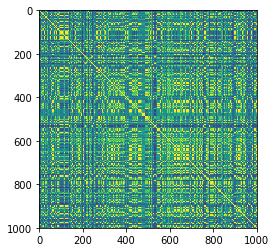

In [34]:
plt.imshow(word_matrix)

In [35]:
import scipy
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=5)  # , whiten=True
pos = pca.fit_transform(word_matrix)

In [36]:
xs, ys = pos[:, 0], pos[:, 1]

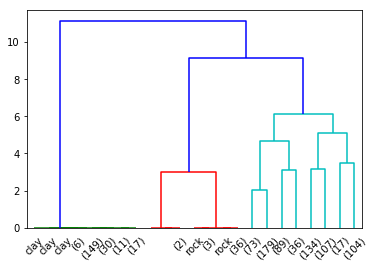

In [37]:
threshold = 0.1
linkage = hierarchy.linkage(pos, method="centroid")
clusters = hierarchy.fcluster(linkage, threshold, criterion="distance")
dendro = hierarchy.dendrogram(linkage, labels=descs, orientation='top',
                              truncate_mode='level', p=4) # last two settings tell it to only show the last 'p'

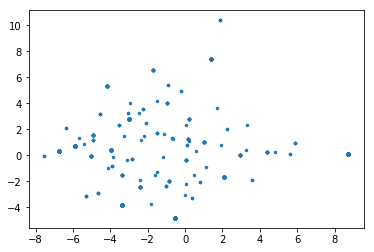

In [38]:
plt.scatter(pos[:, 0], pos[:, 1], s=6);

In [39]:
import sklearn.cluster
import random
random.seed(1)  # set known seed to replicate results

damp_factor = 0.5

# from sklearn.metrics.pairwise import cosine_similarity

# Convert to cosine similarity matrix
# cos_sim = cosine_similarity(compressed)
# , affinity="precomputed"
ap_model = sklearn.cluster.AffinityPropagation(damping=damp_factor)  # , preference=-np.median(compressed)
ap_model.fit(pos)

cluster_centers_idx = ap_model.cluster_centers_indices_
labels = ap_model.labels_
unique_labels = np.unique(labels)
n_clusters_ = len(cluster_centers_idx)
print("Num clusters:", n_clusters_)

Num clusters: 611


In [40]:
import sklearn

C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


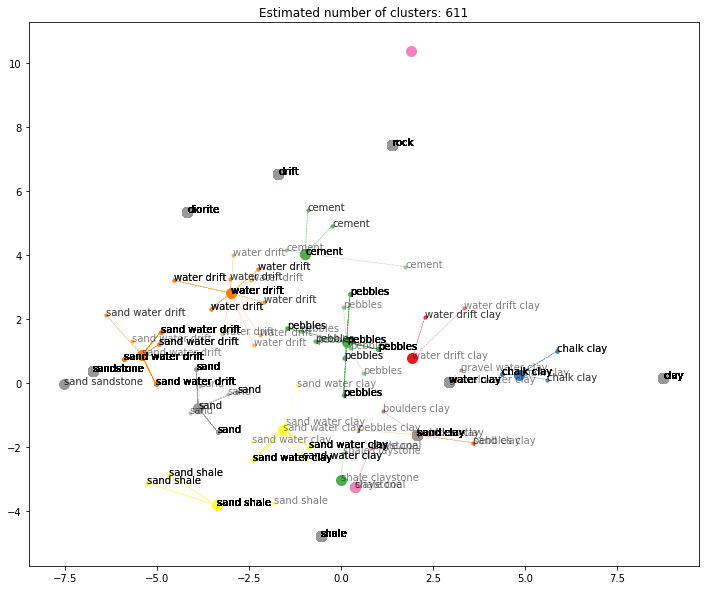

In [41]:
fig, ax = plt.subplots(figsize=(12,10))

cm = plt.get_cmap('Set1')
colors = [cm(1.0*i/n_clusters_) for i in range(n_clusters_)]

count = 0
# for each cluster get all members and plot with same color
for cluster_idx, color in zip(range(n_clusters_), colors):
    in_cluster = labels == cluster_idx
    cluster_set = pos[in_cluster]
    
    cluster_row = cluster_centers_idx[cluster_idx]
    cluster_center = pos[cluster_row]
    
    exemplar = " ".join(tokenize_and_stem(" ".join(str(i) for i in word_matrix[cluster_row]), stopwords))
    
    # Plot cluster exemplar
    ax.scatter(cluster_center[0], cluster_center[1], marker='o', c=color, s=100)
    ax.annotate(" ".join(exemplar.split()[:5]), (cluster_center[0], cluster_center[1]), 
                alpha=1, fontsize=12)
    
    for i, txt in enumerate(word_matrix[in_cluster]):
        if txt == exemplar:
            continue
            
        x, y = cluster_set[i]
        
        # Plot cluster member
        ax.scatter(x, y, marker='o', c=color, alpha=0.5, s=10)
        
        # Plot line between cluster exemplar and member
        plt.plot([cluster_center[0], x], [cluster_center[1], y], c=color, 
                 linestyle='--', linewidth=0.5, alpha=0.6)
        
        # Add text annotation
        txt = descs[list(in_cluster).index(True)]
        ax.annotate(" ".join(txt.split()[0:3]), (x, y), alpha=0.5)
    # End for
    
# End for

plt.title(f"Estimated number of clusters: {n_clusters_}");